## **Importing Data**

In [1]:
! pip3 install matplotlib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Defaulting to user installation because normal site-packages is not writeable


### **1. Train Data**

In [2]:
current_directory_os = os.getcwd()
print(f"Current working directory (using os): {current_directory_os}")

Current working directory (using os): /scratch/kg3756/version45


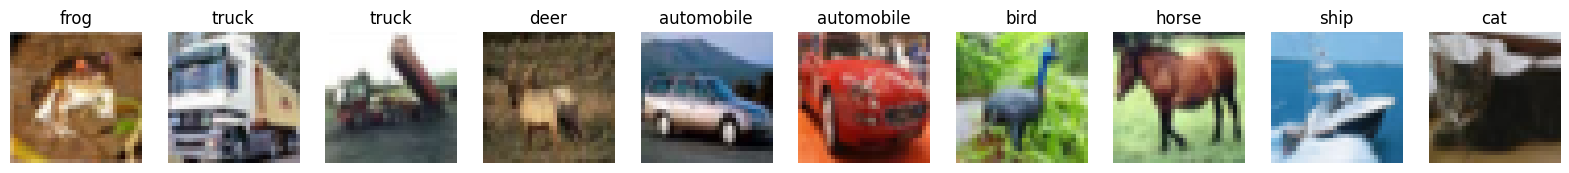

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load all batches and concatenate the images
all_train_images = []
all_train_labels = []
for i in range(1, 6):  # Assuming there are 5 batches named data_batch_1, data_batch_2, ..., data_batch_5
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    batch_images = batch_dict[b'data']
    batch_labels = batch_dict[b'labels']
    batch_images = batch_images.reshape((len(batch_images), 3, 32, 32)).transpose(0, 2, 3, 1)
    all_train_images.append(batch_images)
    all_train_labels.extend(batch_labels)
    
# Concatenate all batches into a single array
train_images = np.concatenate(all_train_images, axis=0)
train_labels = np.array(all_train_labels)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [4]:
train_images.shape

(50000, 32, 32, 3)

### **2. Validation Data**

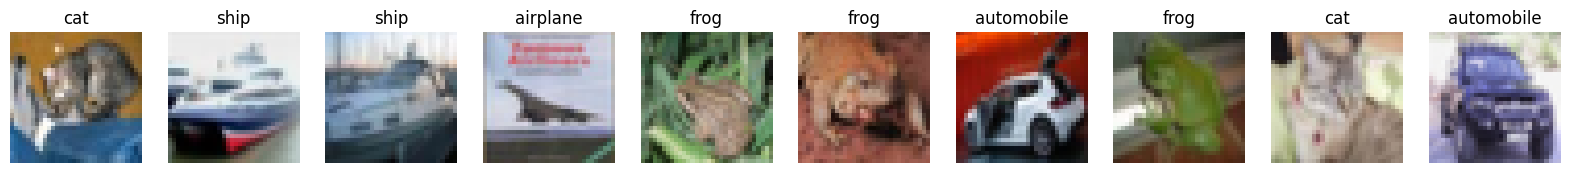

In [5]:
val_batch = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = val_batch[b'data']
val_labels = val_batch[b'labels']

# Reshape the images
val_images = val_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(val_images[i])#.transpose(1,2,0))
    plt.title(label_names[val_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [6]:
val_images.shape

(10000, 32, 32, 3)

### **3. Test Data**

In [7]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('cifar_test_nolabel.pkl')

# Extract images 
test_images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

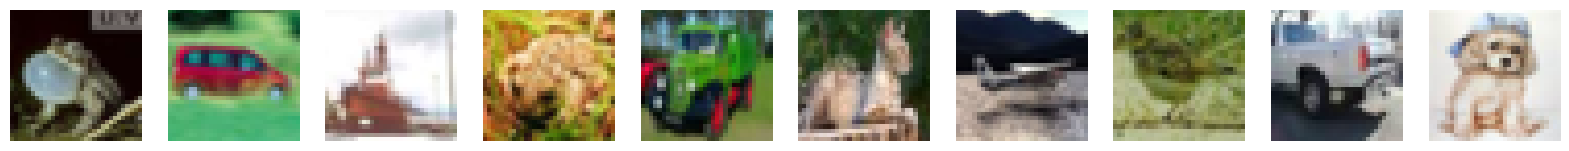

In [8]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
plt.show()

In [9]:
test_images.shape

(10000, 32, 32, 3)

# **Data Pre-Processing**

Converting numpy -> Torch dataset

In [10]:
! pip install torchvision
! pip install torchsummary
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torchvision.ops as ops
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: np.array of shape (N, 32, 32, 3)
        labels: np.array of shape (N,)
        transform: optional torchvision transforms
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Grab the image and label
        img = self.images[idx]  # shape: (32, 32, 3)
        label = self.labels[idx]

        # Convert the NumPy array to a PIL Image
        img = Image.fromarray(img)  # Convert (H, W, C) NumPy array to PIL Image
        
        # If we have a transform (which might normalize etc.), apply it.
        if self.transform:
            img = self.transform(img)

        return img, label

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [11]:
class TestDataset(Dataset):
    def __init__(self, images, transform=None):
        """
        images: np.array of shape (N, 32, 32, 3)
        labels: np.array of shape (N,)
        transform: optional torchvision transforms
        """
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Grab the image and label
        img = self.images[idx]  # shape: (32, 32, 3)

        # Convert the NumPy array to a PIL Image
        img = Image.fromarray(img)  # Convert (H, W, C) NumPy array to PIL Image

        # If we have a transform (which might normalize etc.), apply it.
        if self.transform:
            img = self.transform(img)

        return img

Applying Data Transforms

In [12]:
# Normalization values for CIFAR-10
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # random flip
    transforms.RandomCrop(32, padding=4),      # random crop

    transforms.RandomPerspective(),
    transforms.RandomPosterize(bits=4, p=0.4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering

    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),  # AutoAugment  # AutoAugment
    transforms.ToTensor(),                     # Convert PIL image to tensor
    transforms.Normalize(mean, std)            # normalize
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Creating DataLoader

In [13]:
# Create Dataset objects
train_dataset = CIFAR10Dataset(train_images, train_labels, transform=train_transform)
val_dataset   = CIFAR10Dataset(val_images,   val_labels,   transform=val_transform)
test_dataset = TestDataset(test_images, transform=test_transform)

# Define batch size
batch_size = 128

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np

## **Residual Block**

In [15]:
# --- Define the GhostModule ---
class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        """
        Args:
            in_channels: number of input channels.
            out_channels: desired number of output channels.
            kernel_size: kernel size for the primary convolution.
            ratio: the ratio between output channels and intrinsic channels.
            dw_size: kernel size for the cheap (depthwise) convolution.
            stride: stride for the primary convolution.
            relu: whether to apply a ReLU activation.
        """
        super(GhostModule, self).__init__()
        self.out_channels = out_channels
        # Determine the number of intrinsic feature maps (ceil for safety)
        self.init_channels = math.ceil(out_channels / ratio)
        # Number of ghost feature maps to generate
        self.new_channels = self.init_channels * (ratio - 1)
        
        # Primary convolution to generate intrinsic features
        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, self.init_channels, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm2d(self.init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )
        # Cheap operation to generate the remaining ghost features
        self.cheap_operation = nn.Sequential(
            nn.Conv2d(self.init_channels, self.new_channels, dw_size, 1, dw_size // 2, groups=self.init_channels, bias=False),
            nn.BatchNorm2d(self.new_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )
    
    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        # Concatenate and then trim in case we have extra channels
        out = torch.cat([x1, x2], dim=1)
        return out[:, :self.out_channels, :, :]

# --- Define a GhostBlock based on your BasicBlock ---
class GhostBlock(nn.Module):
    expansion = 1  # Similar to BasicBlock

    def __init__(self, in_channels, out_channels, stride=1, useSEBlock=False, reduction_ratio=16, ghost_ratio=2):
        """
        Args:
            in_channels: input feature channels.
            out_channels: output feature channels.
            stride: stride for the first GhostModule.
            useSEBlock: whether to use a Squeeze & Excitation block.
            reduction_ratio: reduction ratio for the SE block.
            ghost_ratio: ratio used in the GhostModule.
        """
        super(GhostBlock, self).__init__()
        self.useSEBlock = useSEBlock
        
        # First GhostModule (replacing the first conv)
        self.ghost1 = GhostModule(in_channels, out_channels, kernel_size=3, ratio=ghost_ratio, dw_size=3, stride=stride, relu=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second GhostModule (replacing the second conv)
        self.ghost2 = GhostModule(out_channels, out_channels, kernel_size=3, ratio=ghost_ratio, dw_size=3, stride=1, relu=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Optionally, include a Squeeze & Excitation block
        self.se = ops.SqueezeExcitation(out_channels, squeeze_channels=out_channels // reduction_ratio)
        
        # Shortcut connection for matching dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.ghost1(x)))
        out = self.bn2(self.ghost2(out))
        if self.useSEBlock:
            out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


## **Building Resnet**

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.2):
        super(ResNet, self).__init__()

        self.in_channels = 64

        # 1) Initial conv + batch norm
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # 2) Create each layer
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        
        # Add dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # 3) Final linear layer (classification head)
        self.linear = nn.Linear(1024 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        # This method creates a “layer” by stacking multiple BasicBlocks.
        # The first block might have a stride of 2 to downsample, while
        # subsequent blocks have stride=1.
        strides = [stride] + [1]*(blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s, useSEBlock=True))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1) Initial convolution
        out = F.relu(self.bn1(self.conv1(x)))

        # 2) Pass through layer1..layer4
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # 3) Global average pool + flatten
        out = F.avg_pool2d(out, 4)  
        out = out.view(out.size(0), -1)

        # 4) Apply dropout before the final classification layer
        out = self.dropout(out)

        # 5) Classifier
        out = self.linear(out)
        return out

## **Final Resnet Architecture**

In [17]:
def GhostMixNet(num_classes=10):
    # [4,4,4] blocks in each layer, using GhostBlock
    return ResNet(GhostBlock, [4,4,4], num_classes=num_classes)

Checking if GPU available

In [18]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


**Instantiating model for CIFAR-10**

In [19]:
model = GhostMixNet(num_classes=10).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): GhostBlock(
      (ghost1): GhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cheap_operation): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ghost2): GhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(64,

**Number of parameters in the model**

In [20]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 32, 32, 32]          18,432
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]             288
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
       GhostModule-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 32, 32, 32]          18,432
      BatchNorm2d-12           [-1, 32, 32, 32]              64
           Conv2d-13           [-1, 32, 32, 32]             288
      BatchNorm2d-14           [-1, 32,

**Setting Hyperparameters**

In [21]:
# Hyperparameters you can tune
num_epochs = 200         # how many times we loop through the entire dataset
batch_size = 128         # how many images are in each mini-batch
learning_rate = 0.001    # initial learning rate
min_learning_rate = 0.0001
momentum = 0.9           # for SGD
weight_decay = 1e-3      # for regularization (L2 penalty)

**Loss and Optimizer**

In [22]:
# Add this function for Mixup
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [23]:
# CutMix Function
def cutmix_data(x, y, alpha=1.0):
    '''Returns CutMix applied inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    # Random box coordinates
    H, W = x.shape[2:]  
    r_x, r_y = np.random.randint(W), np.random.randint(H)
    r_w, r_h = int(W * np.sqrt(1 - lam)), int(H * np.sqrt(1 - lam))
    
    x1 = np.clip(r_x - r_w // 2, 0, W)
    x2 = np.clip(r_x + r_w // 2, 0, W)
    y1 = np.clip(r_y - r_h // 2, 0, H)
    y2 = np.clip(r_y + r_h // 2, 0, H)

    # Apply CutMix
    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    
    # Adjust lambda
    lam = 1 - ((x2 - x1) * (y2 - y1) / (H * W))
    y_a, y_b = y, y[index]
    
    return x, y_a, y_b, lam

# Loss Function for Mixup/CutMix
def mixup_cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [24]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(momentum, 0.999),
    weight_decay=weight_decay
)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=min_learning_rate)

'\n# Custom scheduler\nscheduler = CosineAnnealingWarmRestartsOnPlateau(\n    optimizer, T_0=10, T_mult=2, eta_min=0.0001, patience=5\n)\n'

# **Training the model**

Epoch [1/200], Step [100/391], Loss: 2.2661
Epoch [1/200], Step [200/391], Loss: 2.1374
Epoch [1/200], Step [300/391], Loss: 2.0774
End of Epoch 1, Learning Rate: 0.001000, Validation Loss: 1.5094, Validation Accuracy: 53.38%

Epoch [2/200], Step [100/391], Loss: 1.9413
Epoch [2/200], Step [200/391], Loss: 1.8730
Epoch [2/200], Step [300/391], Loss: 1.8816
End of Epoch 2, Learning Rate: 0.000999, Validation Loss: 1.3507, Validation Accuracy: 60.26%

Epoch [3/200], Step [100/391], Loss: 1.8266
Epoch [3/200], Step [200/391], Loss: 1.7828
Epoch [3/200], Step [300/391], Loss: 1.7662
End of Epoch 3, Learning Rate: 0.000996, Validation Loss: 1.1694, Validation Accuracy: 71.46%

Epoch [4/200], Step [100/391], Loss: 1.6761
Epoch [4/200], Step [200/391], Loss: 1.7259
Epoch [4/200], Step [300/391], Loss: 1.6669
End of Epoch 4, Learning Rate: 0.000992, Validation Loss: 1.1255, Validation Accuracy: 73.74%

Epoch [5/200], Step [100/391], Loss: 1.6630
Epoch [5/200], Step [200/391], Loss: 1.6840
Epoc

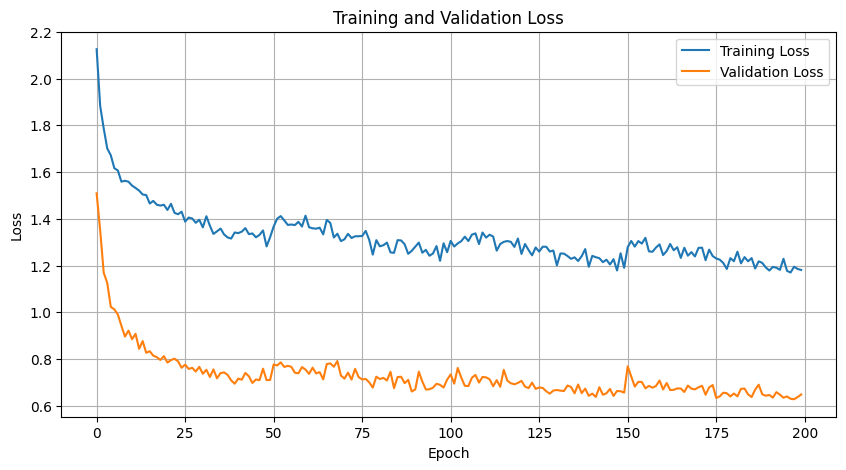

In [25]:
train_losses = []
val_losses = []
last_epoch = False
for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0
    train_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply Mixup
        #inputs_mixed, targets_a, targets_b, lam = mixup_data(inputs, targets)
        # 50% Mixup, 50% CutMix, else no augmentation
        rand_num = np.random.rand()
        if rand_num < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=0.2)
            mixed = True
        elif rand_num < 1.0:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=1.0)
            mixed = True
        else:
            mixed = False  # No augmentation
        
        # 1) Zero gradients
        optimizer.zero_grad()

        # 2) Forward pass
        outputs = model(inputs)

        # 3) Compute loss
        if mixed:
            loss = mixup_cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            loss = criterion(outputs, targets)
            
        # 4) Backprop
        loss.backward()

        # 5) Update parameters
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"Loss: {running_loss/100:.4f}")
            running_loss = 0.0

    # Store training loss for the epoch
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()  # set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Calculate validation loss and accuracy
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = 100. * correct / total
    print(f"End of Epoch {epoch+1}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%\n")

    # Step the scheduler based on validation loss
    scheduler.step()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [26]:
def predict(test_images, test_transform, model, device):
    predictions = []
    
    with torch.no_grad():
        for i, image in enumerate(test_loader):
            image = image.to(device)
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            predictions.append(predicted.item())
    
    return predictions

In [27]:
model.eval()
test_predictions = predict(test_loader, test_transform, model, device)

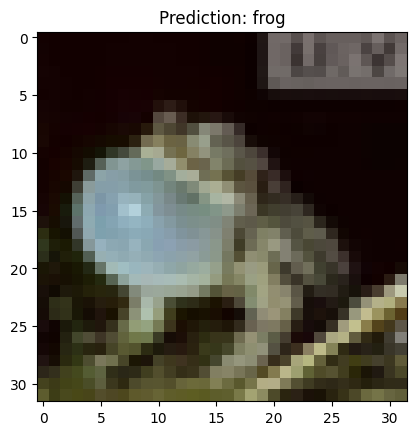

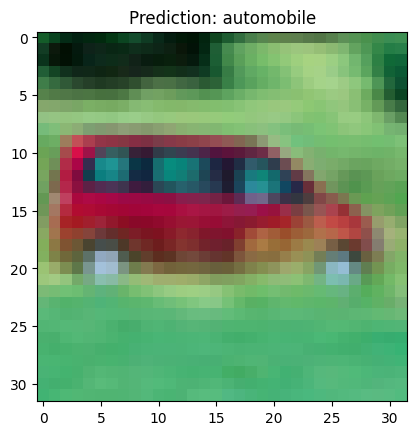

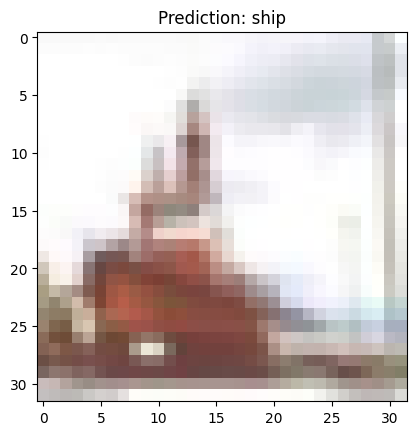

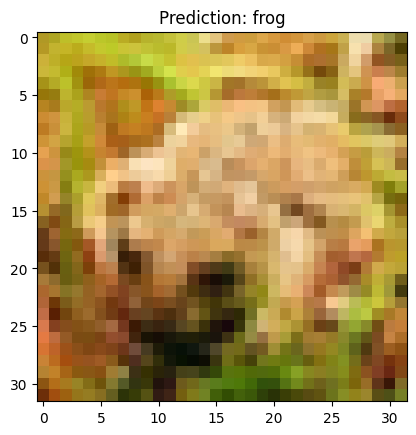

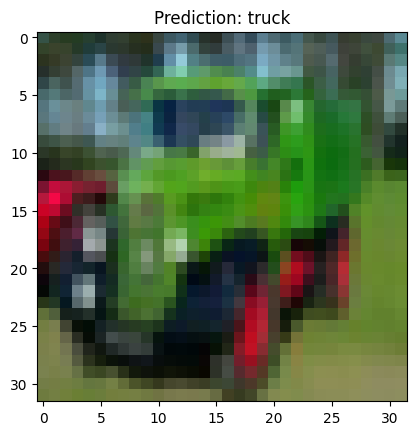

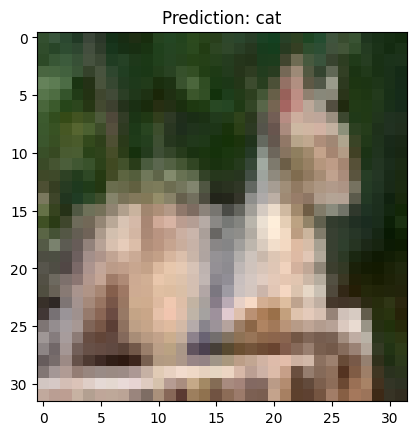

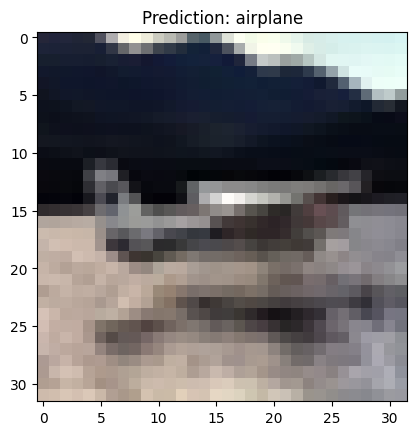

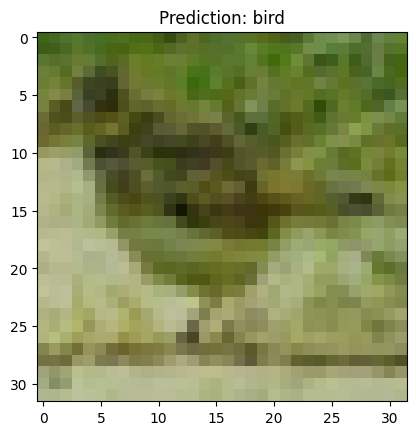

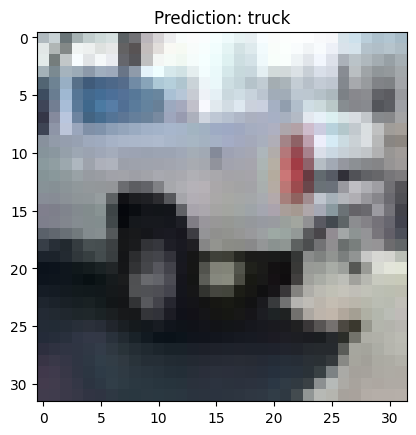

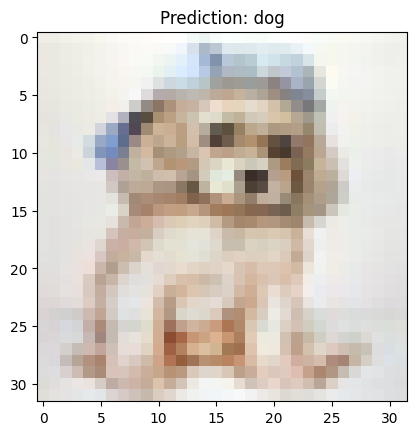

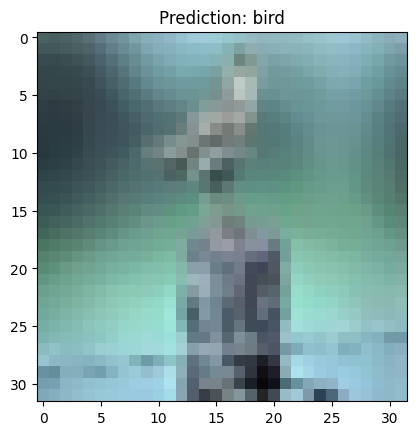

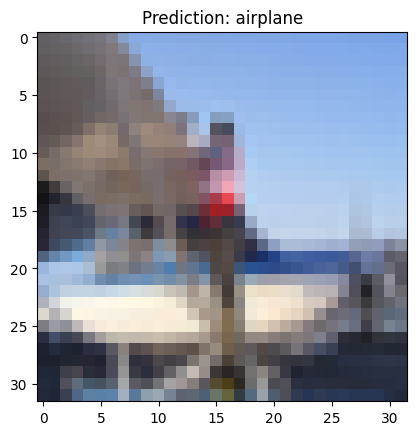

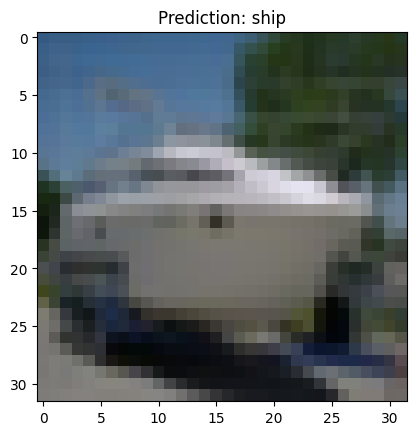

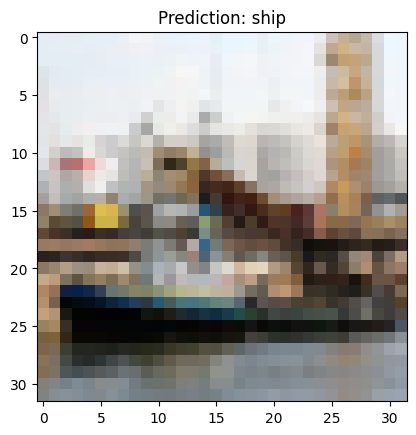

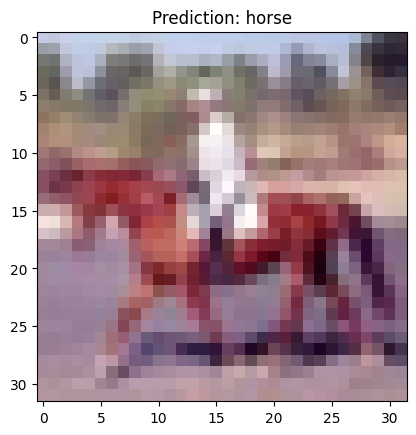

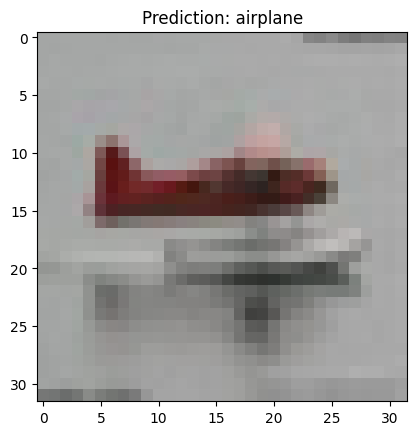

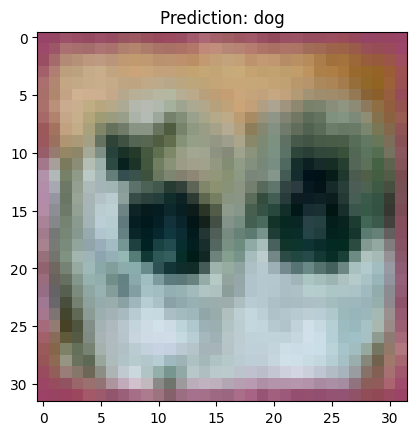

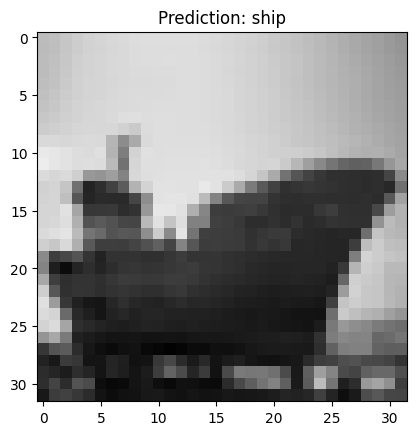

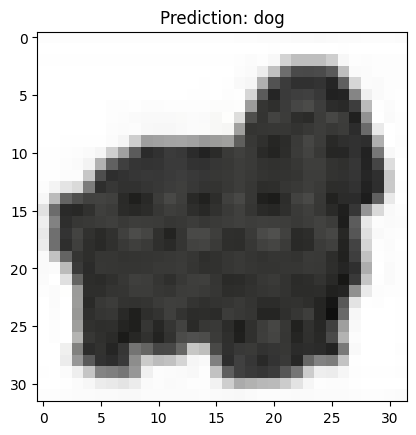

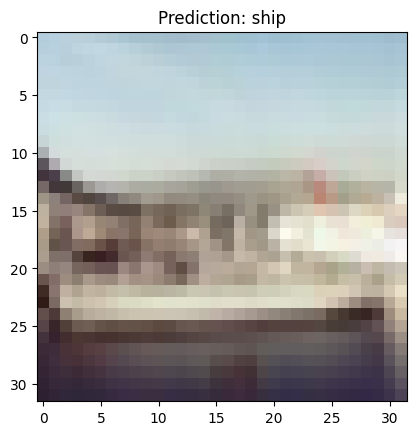

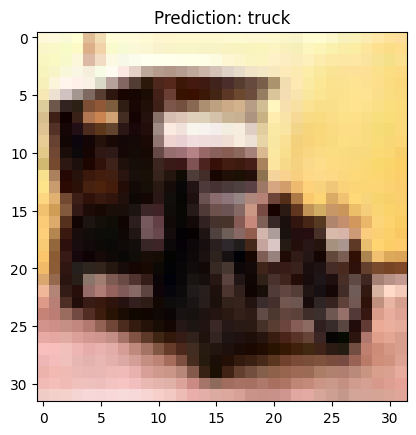

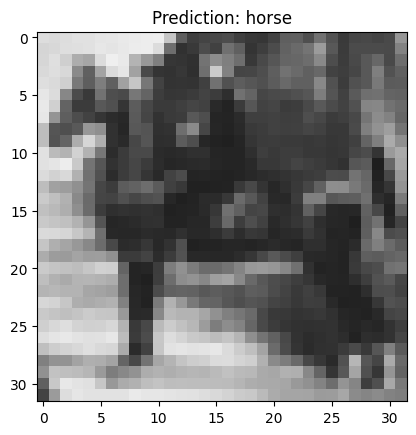

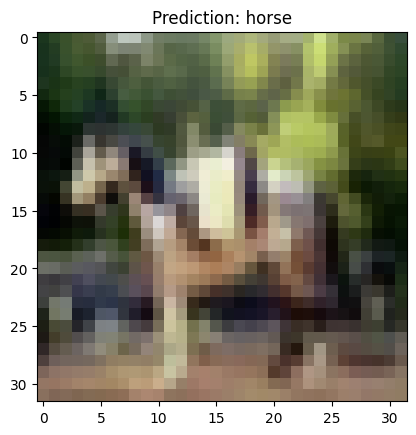

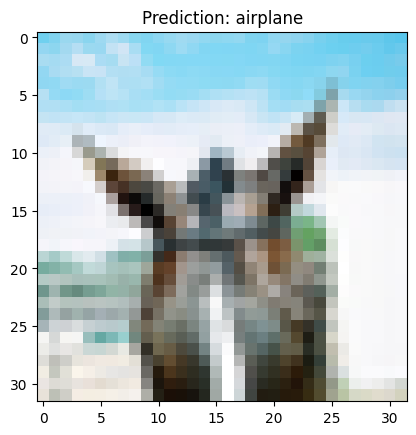

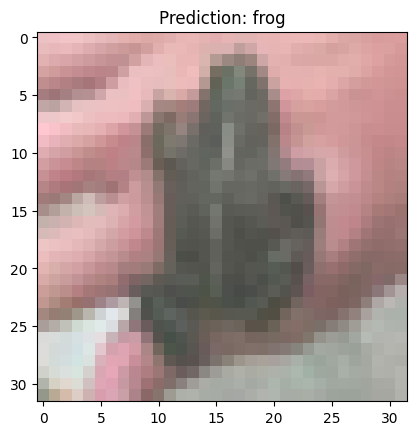

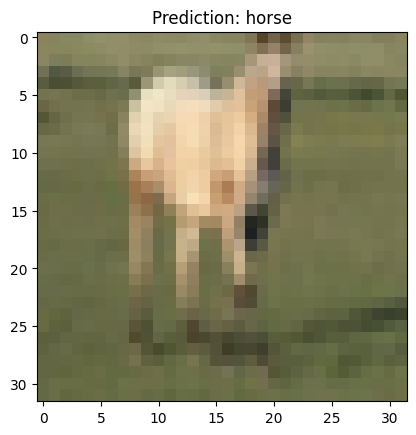

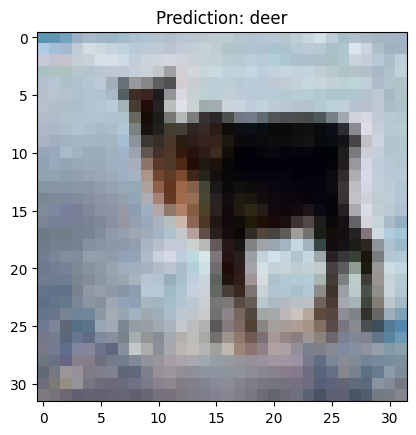

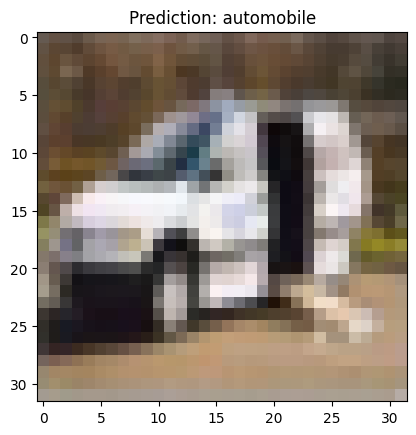

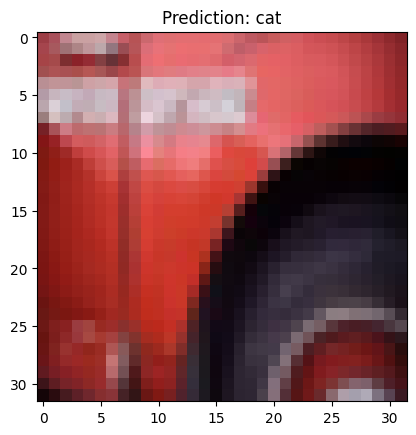

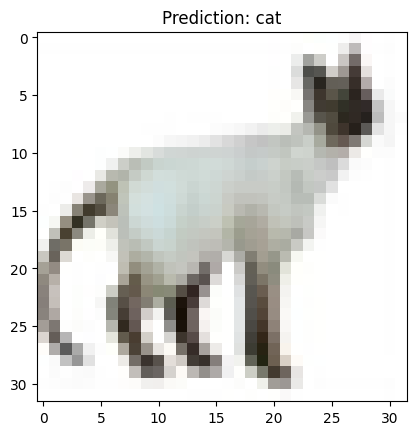

In [28]:
for i in range(30):
    plt.imshow(test_images[i])  # Transpose to (height, width, channels)
    plt.title(f'Prediction: {label_names[test_predictions[i]].decode("utf-8")}')
    plt.show()

In [29]:
prediction_df = pd.DataFrame({'ID': range(len(test_predictions)), 'Labels': test_predictions})

# Save DataFrame to CSV file
prediction_file = 'submission.csv'
prediction_df.to_csv(prediction_file, index=False)

In [30]:
prediction_df.describe()

,ID,Labels
count,10000.00000,10000.000000
mean,4999.50000,4.556500
std,2886.89568,2.837501
min,0.00000,0.000000
25%,2499.75000,2.000000
50%,4999.50000,5.000000
75%,7499.25000,7.000000
max,9999.00000,9.000000
